# CNN Interpretation - Sensitive Area Detection

Note: This notebook is desinged to run with GPU runtime.

####[CIS-01]
Import modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, saving
from tensorflow.keras.datasets import mnist

####[CIS-02]
Define a function to detect the sensitive areas in the second filters against the input image, and generate a heatmap.

In [9]:
def get_heatmap(model, last_conv_layer, target_image, label):
    target_image = target_image.reshape(1, 28*28)
    pred_output = model.outputs[0][:, label]
    target_model = models.Model(model.inputs[0], pred_output)
    fitler_model = models.Model(model.inputs[0], last_conv_layer.output)
    conv_layer_output_val = fitler_model.predict(target_image, verbose=0)[0]

    with tf.GradientTape() as tape:
        outputs = target_model(target_image)
    bias_grads = tape.gradient(outputs, last_conv_layer.weights[1]) # bias
    bias_grads_vals = bias_grads.numpy()

    heatmap = np.zeros([14, 14])
    for i in range(last_conv_layer.output.shape[-1]):
        if bias_grads_vals[i] > 0:
            heatmap += conv_layer_output_val[:, :, i] * bias_grads_vals[i]
    heatmap /= np.max(heatmap)

    heatmap2 = np.uint8(255 * cv2.resize(heatmap, (28, 28)))
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
    target_image2 = np.uint8(255 * target_image.reshape(28, 28))
    target_image2 = cv2.applyColorMap(target_image2, cv2.COLORMAP_BONE)
    superimposed_img = heatmap2 + target_image2 * 0.6
    cv2.imwrite('/tmp/result.jpg', superimposed_img)

    return heatmap, preprocessing.image.load_img('/tmp/result.jpg')

####[CIS-03]
Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


####[CIS-04]
Mount your Google Drive on `/content/gdrive`.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


####[CIS-05]
Confirm that the exported model file `MNIST_double.keras` is on your Google Drive.

In [5]:
!ls -lh '/content/gdrive/My Drive/MNIST_double.keras'

-rw------- 1 root root 38M Feb 16 20:57 '/content/gdrive/My Drive/MNIST_double.keras'


####[CIS-06]
Restore the model from the exported model file.

In [6]:
model = saving.load_model('/content/gdrive/My Drive/MNIST_double.keras')
model.summary()

Model: "CNN_double_layer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter1 (Conv2D)                │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1 (MaxPooling2D)          │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter2 (Conv2D)                │ (None, 14, 14, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2 (MaxPooling2D)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden (Dense)                       │ (None, 1024)                │       3,212,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,823,904 (37.48 MB)

 Trainable params: 3,274,634 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,549,270 (24.98 MB)

####[CIS-07]
Show heatmaps for sample images.

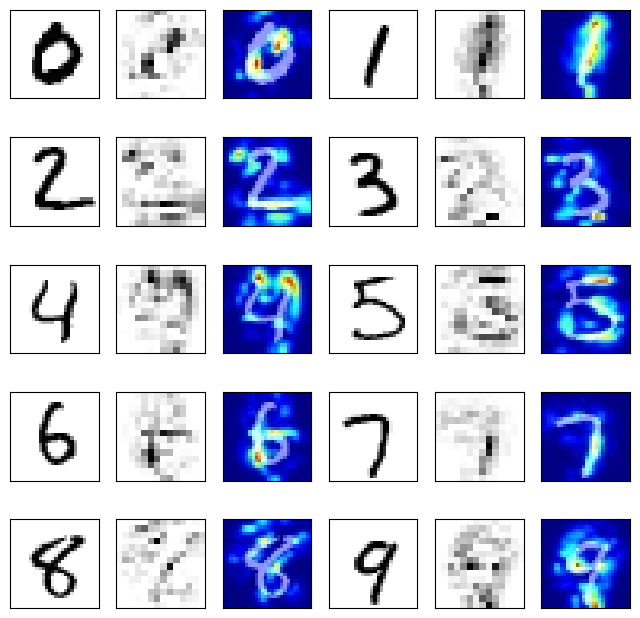

In [10]:
fig = plt.figure(figsize=(8, 8))
last_conv_layer = model.get_layer('conv_filter2')
i = 1
for label, img in enumerate(test_images[[3, 5, 1, 32, 4, 15, 21, 254, 84, 12]]):
    heatmap, superimposed = get_heatmap(model, last_conv_layer, img, label)

    subplot = fig.add_subplot(5, 6, i)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(heatmap, vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(superimposed)

    i += 3